# Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os 
import PIL
import IPython

import tensorflow as tf
import tensorflow.keras as keras
from keras import layers
from keras.models import Sequential

import pathlib 
import zipfile

In [ ]:
!pip install -q -U keras-tuner
import kerastuner as kt

     |████████████████████████████████| 71kB 5.8MB/s 


# Files

## Dataset download

In [ ]:
data_path = 'drive/My Drive/Data.zip'
zip_ref = zipfile.ZipFile(data_path,'r')
zip_ref.extractall('/tmp/')

In [ ]:
data_dir = pathlib.PosixPath('/tmp/Data')

## Images count

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg'))) + len(list(data_dir.glob('*/*.png'))) + len(list(data_dir.glob('*/*.jpeg'))) 
print(image_count)

2048


# Display some images

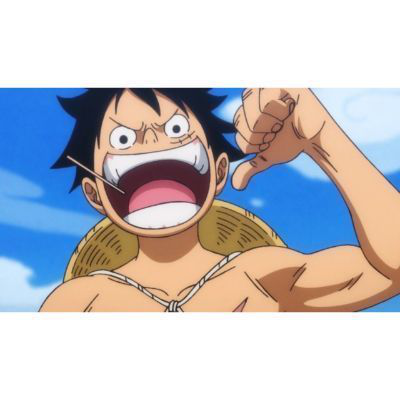

In [ ]:
Luffy = list(data_dir.glob('Luffy/*'))
PIL.Image.open(str(Luffy[0]))

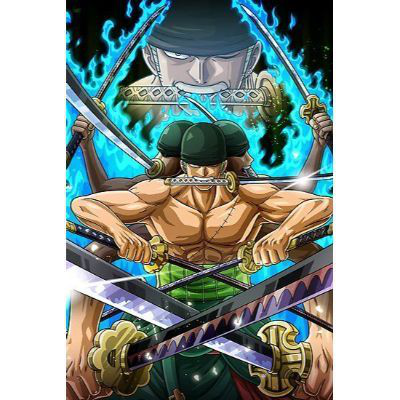

In [ ]:
Zoro = list(data_dir.glob('Zoro/*'))
PIL.Image.open(str(Zoro[0]))

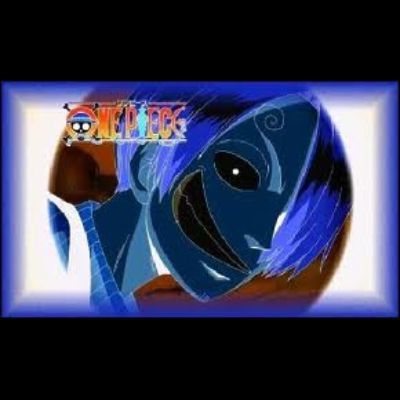

In [ ]:
Sanji = list(data_dir.glob('Sanji/*'))
PIL.Image.open(str(Sanji[0]))

# Model builder

## Some parameters 

In [ ]:
import random

In [ ]:
random.seed()
seed = random.randint(0,100)

In [ ]:
batch_size = 5
width = 180
height = 180

## Training dataset definition

In [ ]:
train_dataset = keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.125,
    subset="training",
    seed=seed,
    image_size=(height,width),
    batch_size=batch_size
)

Found 2048 files belonging to 3 classes.
Using 1792 files for training.


In [ ]:
classes_count = 3
class_names = train_dataset.class_names
print(class_names)

['Luffy', 'Sanji', 'Zoro']


## Validation dataset definition

In [ ]:
val_dataset = keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.125,
    subset="validation",
    seed=seed,
    image_size=(height, width),
    batch_size=batch_size
)

Found 2048 files belonging to 3 classes.
Using 256 files for validation.


# Data augmentation

In [ ]:
data_augmentation = Sequential([
                                      layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(height,width,3)),
                                      layers.experimental.preprocessing.RandomRotation(0.2),
                                      layers.experimental.preprocessing.RandomZoom(0.1)
])

In [ ]:
def model_builder(hp):
  
   hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
   hp_learning_rate = hp.Choice('learning_rate',values=[1e-2, 1e-3, 1e-4])

   model = Sequential()

   model.add(layers.Conv2D(filters=60,kernel_size=3,activation='relu')) 
   model.add(layers.MaxPool2D())
   model.add(layers.Conv2D(filters=30,kernel_size=3,activation='relu'))
   model.add(layers.MaxPool2D())
   model.add(layers.Conv2D(filters=15,kernel_size=3,activation='relu'))
   model.add(layers.MaxPool2D())
   model.add(layers.Dropout(0.5))
   model.add(layers.Flatten())
   model.add(layers.Dense(units=hp_units,activation='relu'))
   model.add(layers.Dense(classes_count,activation='softmax'))

   model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])
   
   return model

# Hypertuning 

In [ ]:
tuner = kt.Hyperband(
    model_builder,
    objective = 'val_accuracy',
    max_epochs = 10,
    factor = 3
)

In [ ]:
tuner.search(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    
)

Trial 30 Complete [00h 01m 11s]
val_accuracy: 0.5625

Best val_accuracy So Far: 0.7734375
Total elapsed time: 00h 14m 53s
INFO:tensorflow:Oracle triggered exit


## Get the optimal parameters

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Model fit

In [ ]:
model = tuner.hypermodel.build(best_hps)

In [ ]:
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    verbose=1
)

Epoch 1/20
359/359 [==============================] - 8s 20ms/step - loss: 6.5804 - accuracy: 0.4012 - val_loss: 1.0317 - val_accuracy: 0.5312
Epoch 2/20
359/359 [==============================] - 7s 19ms/step - loss: 0.9801 - accuracy: 0.5618 - val_loss: 0.9397 - val_accuracy: 0.5547
Epoch 3/20
359/359 [==============================] - 7s 19ms/step - loss: 0.8081 - accuracy: 0.6377 - val_loss: 0.9078 - val_accuracy: 0.6094
Epoch 4/20
359/359 [==============================] - 7s 20ms/step - loss: 0.7036 - accuracy: 0.7043 - val_loss: 0.8702 - val_accuracy: 0.6484
Epoch 5/20
359/359 [==============================] - 7s 20ms/step - loss: 0.5710 - accuracy: 0.7626 - val_loss: 0.8147 - val_accuracy: 0.7031
Epoch 6/20
359/359 [==============================] - 7s 19ms/step - loss: 0.4803 - accuracy: 0.8259 - val_loss: 0.7611 - val_accuracy: 0.7188
Epoch 7/20
359/359 [==============================] - 7s 19ms/step - loss: 0.4589 - accuracy: 0.8409 - val_loss: 0.7199 - val_accuracy: 0.7109

# Model summary 

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 178, 178, 60)      1680      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 60)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 30)        16230     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 30)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 15)        4065      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 15)        0         
_________________________________________________________________
dropout (Dropout)            (None, 20, 20, 15)        0

# Predictions

In [ ]:
from google.colab import files
from keras.preprocessing import image

In [ ]:
class_names = train_dataset.class_names
class_names

['Luffy', 'Sanji', 'Zoro']

In [1]:
def prediction(): 
  for filename in uploaded.keys():

    path = "/content/" + filename
    im = image.load_img(path,target_size=(180,180))
    
    inputs = image.img_to_array(im)

    inputs = np.vstack([inputs])

    inputs = tf.expand_dims(inputs,axis=0) #Creates a batch

    
    predictions = model.predict(inputs) #Make a prediction based on input values

    score = tf.nn.sigmoid(predictions[0]) #We use predictions[0] since predictions is a [[classes_count]] shape vector. 
                                          #(Could've used np.squeeze(predictions) instead)
    #Sigmoid will return the probability of the image belonging to each class.
    #Rather than a probability distribution, it is a set of probabilities.
    #Each nlabel has its own probability, which do not depend on another label's probability.
    #Since we can have more than one character in the image, a sigmoid fits better than softmax which is a probability distribution. 
    #In our case, { P(X=Luffy) = score[0]
    #               P(X=Sanji) = score[1]
    #               P(X=Zoro) = score[2]
    #               P(X=Unknown) = score[3]
    #             } 

    print("Image: ", path)
    for i in range (len(score)):
      print("\nProbability of being " + class_names[i] + \
              ": ", 100*score[i].numpy() , "%")

    #print(predictions)

    object_score = np.max(score)
    object_class = class_names[np.argmax(score)]
    #np.argmax(score) returns the index with the highest score 
    #np.max(score) returns the highest probability of our input belonging to one of our classes

    plt.figure()
    plt.title("This image most likely belongs to " +str(object_class)+ \
              " category with a " + str(object_score) + " score.\n\n")
    
    plt.imshow(im)


    print("This image most likely belongs to " +str(object_class)+ \
          " category with a " + str(object_score) + " score. \n\n"
    )

In [ ]:
uploaded = files.upload() 

Saving Luffy.jpg to Luffy.jpg
Saving Sanji.jpg to Sanji.jpg


Image:  /content/Luffy.jpg

Probability of being Luffy:  73.02703261375427 %

Probability of being Sanji:  50.01229643821716 %

Probability of being Zoro:  50.08784532546997 %
This image most likely belongs to Luffy category with a 0.7302703 score. 


Image:  /content/Sanji.jpg

Probability of being Luffy:  53.62637639045715 %

Probability of being Sanji:  70.04770636558533 %

Probability of being Zoro:  50.12798309326172 %
This image most likely belongs to Sanji category with a 0.70047706 score. 




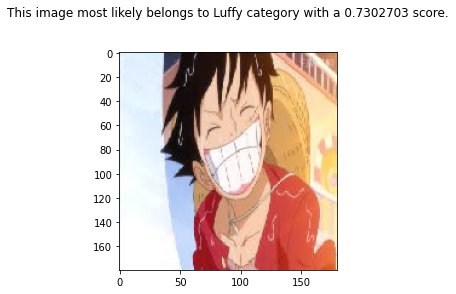

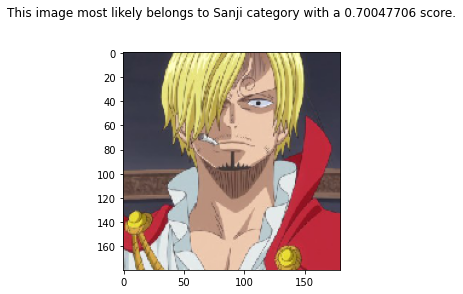

In [ ]:
prediction()

In [ ]:
model.save('drive/My Drive/Object_Detector_Model_KerasTuner_10epochs.h5')